In [333]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="dsa3101-435110")  # Brandon
# client = bigquery.Client(project="dsa3101-434713")  # Swislar
# client = bigquery.Client(project="sturdy-cable-435110-g9") # Yan Rong

In [3]:

# Data cleaning function for categories
def clean_categories(googleAnalytics_df: pd.DataFrame):
    """
    Cleans category based on product.v2ProductCategory AS 'Category' 
    and product.v2ProductName AS 'product_name'
    """
    # Pandas
    googleAnalytics_df['Category'].replace(
        ['(not set)', '${productitem.product.origCatName}'], np.nan, inplace=True)
    googleAnalytics_df['Category'].replace(
        ['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace=True)
    googleAnalytics_df['Category'].replace(
        ['More Bags', 'Backpacks'], 'Bags', inplace=True)
    googleAnalytics_df['Category'].replace(
        'Android', 'Apparel', inplace=True)
    googleAnalytics_df['Category'].replace(
        'Waze', 'Electronics', inplace=True)
    # Regex
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Waze.*(Men's|Women's|Socks)", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"(oz|Bottle|Cup)", case=True, na=False), "Category"] = "Drinkware"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Journal|Notebook", case=True, na=False), "Category"] = "Notebooks & Journals"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Bag|Backpack|Tote|Rucksack", case=True, na=False), "Category"] = "Bags"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Gift Card", case=True, na=False), "v"] = "Gift Cards"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Electronics|Device|Headphones|Earbuds|Earphones", case=True, na=False), "Category"] = "Electronics"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Cap|Hat", case=True, na=False), "Category"] = "Headgear"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Pen", case=True, na=False), "Category"] = "Office"
    return googleAnalytics_df

# Q1


What are the key factors influencing customer purchasing behavior?

- Analyze historical sales data to identify patterns and trends.
- Develop customer segmentation models based on purchasing behavior.


### Type of purchases and revenue by month


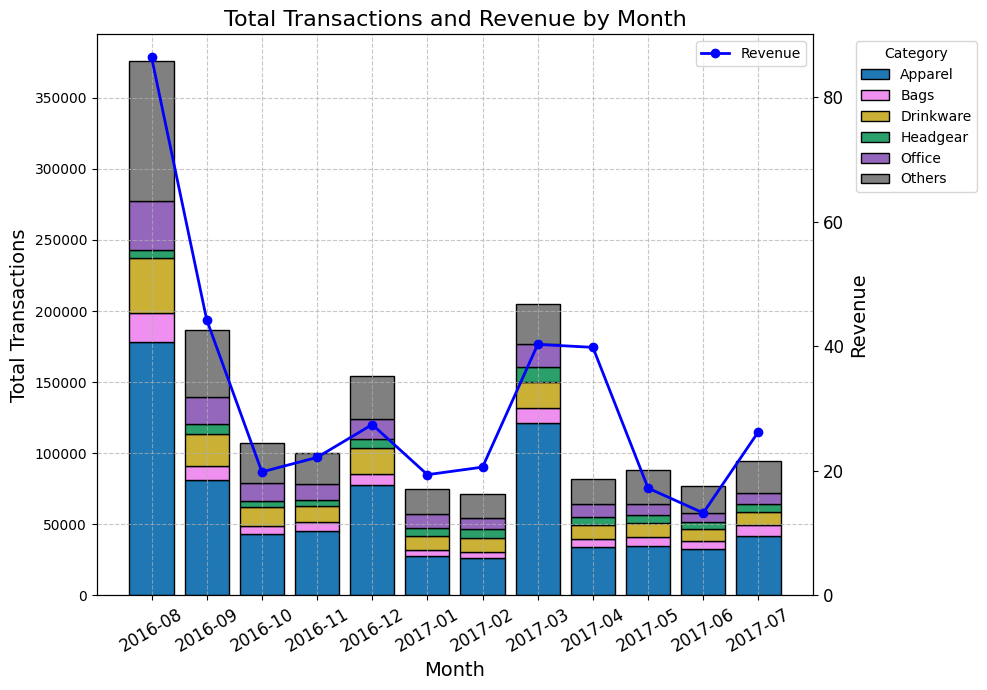

In [9]:
query = """
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, product.v2ProductName AS product_name, SUM(totals.transactions) AS TotalTransactions, SUM(totals.totalTransactionRevenue) AS TotalRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        GROUP BY MONTH, Category, product_name
        HAVING TotalTransactions > 0
        ORDER BY MONTH, Category
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Clean categories
result_df = clean_categories(result_df)

# Since '2017-08' only contains 1 day of data
result_df = result_df.query("MONTH < '2017-08'")

# Extract the top 6 categories
top_categories = result_df.groupby(
    'Category')['TotalTransactions'].sum().nlargest(6).index

# Create a new column for categories
result_df['Category'] = result_df['Category'].apply(
    lambda x: x if x in top_categories else 'Others'
)

# Pivot the DataFrame to wide format
pivot_df = result_df.pivot_table(
    index='MONTH', columns='Category', values=['TotalTransactions', 'TotalRevenue'], aggfunc='sum', fill_value=0)


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 7))

# Initialize the bottom parameter
bottoms = [0] * len(pivot_df)

# Define colors
category_colors = {
    'Apparel': '#1f77b4',  # Blue
    'Bags': '#EF8FEF',  # Pink
    'Drinkware': '#CAB136',  # Khaki
    'Headgear': '#2BA06B',  # Forest green
    "Notebooks & journals": '#2B89A0',   # Turquoise
    'Office': '#9467bd',   # Purple
    'Others': '#808080'  # Gray for 'Other'
}

# Plot the stacked bar chart on the primary y-axis
for category, color in category_colors.items():
    if category in pivot_df.TotalTransactions.columns:
        ax1.bar(pivot_df.index, pivot_df.TotalTransactions[category], bottom=bottoms,
                label=category, color=color, edgecolor='black')
        bottoms = [bottoms[j] + pivot_df.TotalTransactions[category].iloc[j]
                   for j in range(len(bottoms))]

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(pivot_df.index, pivot_df.TotalRevenue.sum(axis=1)/1e12, marker='o',
         color='b', linestyle='-', linewidth=2, label='Revenue')

# Add labels and titles
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Total Transactions', fontsize=14)
ax1.set_title('Total Transactions and Revenue by Month', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=12)
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_ylabel('Revenue', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper right')
ax2.set_ylim(bottom=0)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

2016-08: Large number of transactions.

2017-03: There is a large increase of transactions in the apparel category.


### Exit rate by Page Title


In [ ]:
# Exit rate by pages
query = f"""
        SELECT hits.page.pageTitle as PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS ExitRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.type='PAGE'
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                                           PageTitle   Views  ExitRate
0                                               Home  630465  0.164693
1                                Google Online Store  393684  0.510486
2                                      Shopping Cart  209266  0.020534
3  YouTube | Shop by Brand | Google Merchandise S...  157715  0.283683
4              The Google Merchandise Store - Log In  117629  0.050243
5  Men's T-Shirts | Apparel | Google Merchandise ...  101866  0.120570
6                               Store search results   78035  0.025322
7  Men's Outerwear | Apparel | Google Merchandise...   56217  0.057829
8        Backpacks | Bags | Google Merchandise Store   53449  0.017493
9                 Apparel | Google Merchandise Store   51610  0.048983 



Exit rates are the lowest when items from a specific category are being displayed


### Bounce rates by Page Title


In [ ]:
# Bounce rate by pages
query = f"""
        SELECT hits.page.pageTitle AS PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits
        WHERE hits.type = 'PAGE' AND hits.hitNumber = 1
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """
rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                                           PageTitle   Views  BounceRate
0                                Google Online Store  339352    0.592002
1                                               Home  275170    0.374627
2  YouTube | Shop by Brand | Google Merchandise S...   79314    0.563873
3  Men's T-Shirts | Apparel | Google Merchandise ...   26342    0.465758
4              The Google Merchandise Store - Log In   16321    0.361191
5                                   Page Unavailable   15965    0.404447
6                                      Shopping Cart    9428    0.454709
7  Men's Outerwear | Apparel | Google Merchandise...    7439    0.436618
8                    Bags | Google Merchandise Store    6928    0.460450
9               Drinkware | Google Merchandise Store    6834    0.557799 



### Relationship between transactions, page views, time on site and revenue


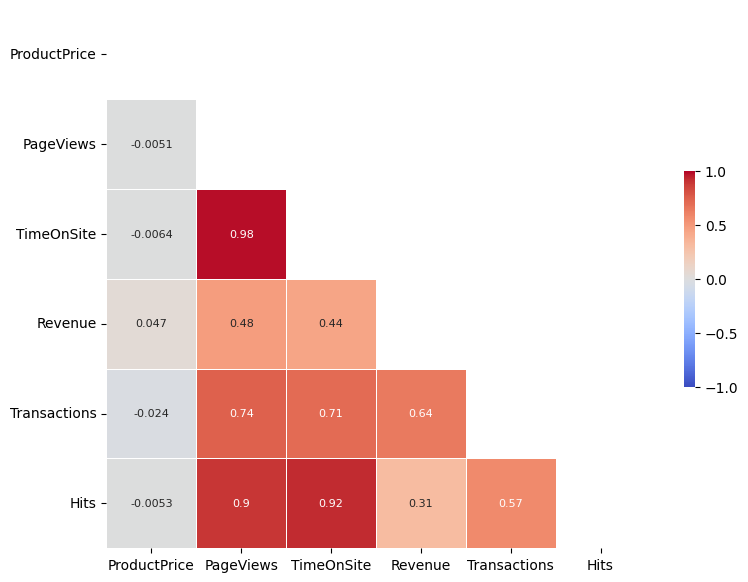

In [ ]:
query = f"""
        SELECT channelGrouping AS ChannelGrouping, device.browser AS Browser, geoNetwork.country AS Country, prod.productListPosition AS ProductListPosition, hits.page.pagePath AS PagePath, prod.v2ProductCategory AS ProductCategory,  trafficSource.source AS TrafficSource, prod.productPrice AS ProductPrice, prod.productListName AS ProductListName, hits.promotionActionInfo.promoIsView AS PromoIsView, hits.promotionActionInfo.promoIsClick AS PromoIsClick,
        SUM(totals.pageviews) AS PageViews,  SUM(totals.timeOnSite) AS TimeOnSite, SUM(totals.totalTransactionRevenue)/1000000 AS Revenue, SUM(totals.transactions) AS Transactions, COUNT(totals.hits) AS Hits
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits, UNNEST(hits.product) as prod
        GROUP BY 1,2,3,4,5,6,7,8,9,10,11
        """

rows = client.query(query)

result_df = rows.to_dataframe()

corr_matrix = result_df[['ProductPrice', 'PageViews',
                         'TimeOnSite', 'Revenue', 'Transactions', 'Hits']].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 7))
heatmap = sns.heatmap(corr_matrix,
                      square=True,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 8})
ax.set_yticklabels(corr_matrix.columns, rotation=0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Visualisation of Customer Recency


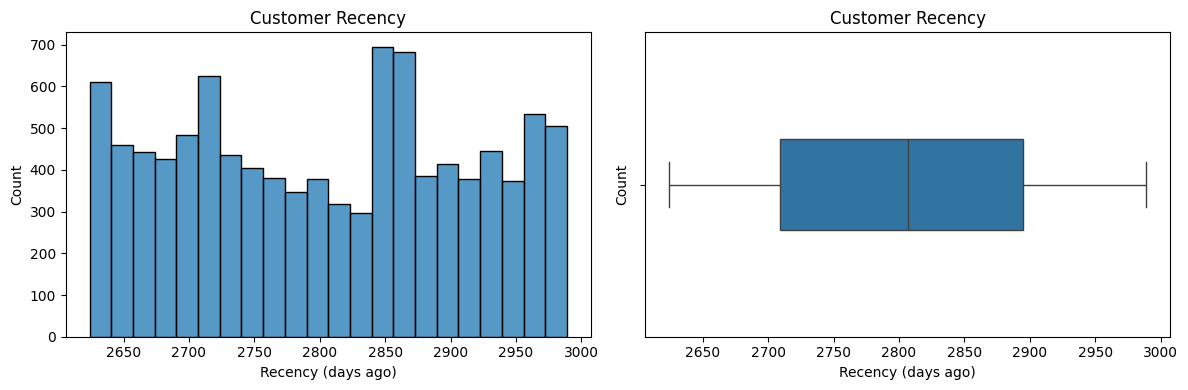

In [14]:
query = f"""
    WITH CustomerRecency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    -- Number of days between the current date and the date of last purchase
    SELECT
        visitorId,
        DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
    FROM
        CustomerRecency
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(result_df.recency, ax=axes[0])
axes[0].set_title('Customer Recency')
axes[0].set_xlabel('Recency (days ago)')
axes[0].set_ylabel('Count')

sns.boxplot(x=result_df.recency, ax=axes[1], width=0.3)
axes[1].set_title('Customer Recency')
axes[1].set_xlabel('Recency (days ago)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Visualisation of Customer Frequency


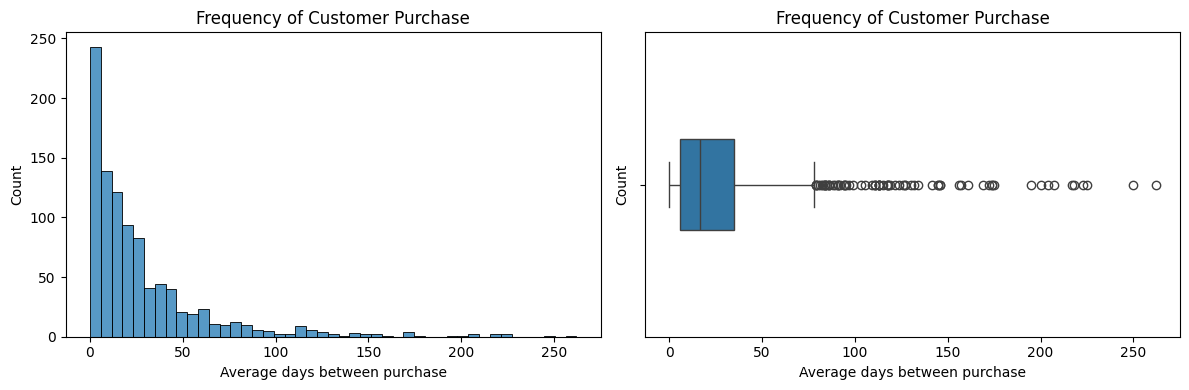

In [13]:
query = f"""
    WITH CustomerFrequency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            COALESCE(totals.transactions, 0) AS transactions,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions > 0
    ),
    -- Get the date the current purchase and the date of the previous purchase for each customer
    LaggedCustomerFrequency AS (
        SELECT
            LAG(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    date
                )
            AS previousDate,
            visitorId,
            date
        FROM
            CustomerFrequency
    ),
    -- Number of days between each transaction for each customer
    frequencyData AS (
        SELECT
            visitorId,
            DATE_DIFF(LaggedCustomerFrequency.date, LaggedCustomerFrequency.previousDate, DAY) AS diffDays
        FROM
            LaggedCustomerFrequency
        WHERE
            LaggedCustomerFrequency.previousDate IS NOT NULL
    )

    SELECT
        visitorId,
        AVG(diffDays) AS frequency
    FROM
        frequencyData
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(result_df.frequency, ax=axes[0])
axes[0].set_title('Frequency of Customer Purchase')
axes[0].set_xlabel('Average days between purchase')
axes[0].set_ylabel('Count')

sns.boxplot(x=result_df.frequency, ax=axes[1], width=0.3)
axes[1].set_title('Frequency of Customer Purchase')
axes[1].set_xlabel('Average days between purchase')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Visualisation of Customer Monetary


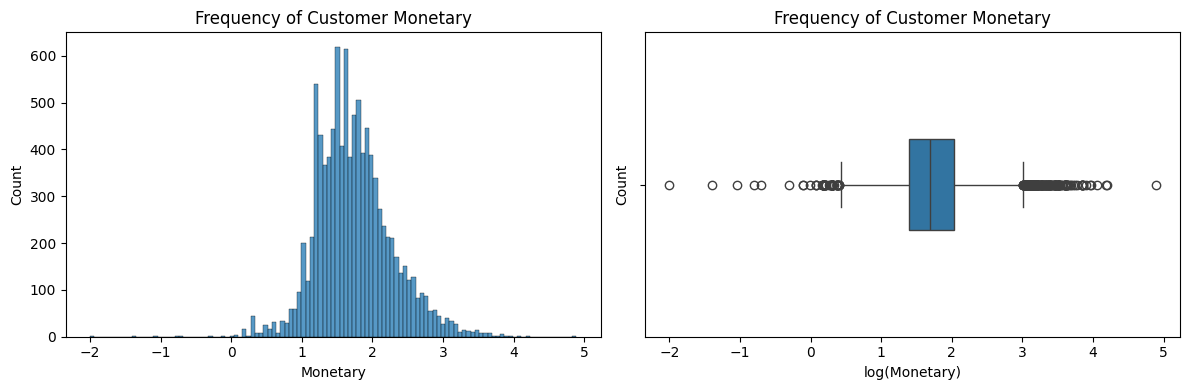

In [17]:
query = f"""
    WITH CustomerMonetary AS (
        SELECT
            fullVisitorId AS visitorId,
            COALESCE(totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    SELECT
        visitorId,
        SUM(transactionRevenue)/1e6 AS monetary
    FROM
        CustomerMonetary
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(np.log10(result_df.monetary), ax=axes[0])
axes[0].set_title('Frequency of Customer Monetary')
axes[0].set_xlabel('Monetary')
axes[0].set_ylabel('Count')

sns.boxplot(x=np.log10(result_df.monetary), ax=axes[1], width=0.3)
axes[1].set_title('Frequency of Customer Monetary')
axes[1].set_xlabel('log(Monetary)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Customer segmentation model


RFM (Recency, Frequency, Monetary) analysis is used to segment the customers before running behaviour-based clustering algorithm () to automatically find customer groups


In [3]:
query = f"""
    -- Selecting the neccessary columns for RMF analysis
    WITH RFMData AS (
        SELECT
            visitNumber,
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            COALESCE(totals.transactions, 0) AS transactions,
            COALESCE(totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            date != "None"
        ORDER BY
            visitorID,
            visitNumber
    ),
    -- Calculate recency score by calculating the number of days since last purchase
    recencyScore AS (
        SELECT
            visitorId,
            DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
        FROM
            RFMData
        GROUP BY
            visitorId
    ),
    -- Creating a new column of the next purchase date by taking date from next row for the customer
    leadData AS (
        SELECT
            LEAD(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    visitorId,
                    visitNumber
                )
            AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            RFMData
    ),
    -- Set next day to be null when for the latest transaction
    fixedLeadData AS (
        SELECT
            COALESCE(nextDate, CURRENT_DATE()) AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            leadData
    ),
    -- Calculate the number of days between data and next date columns
    frequencyData AS (
        SELECT
            RFMData.visitorId,
            DATE_DIFF(lead.date, lead.nextDate, DAY) AS diffDays
        FROM
            RFMData
        INNER JOIN
            fixedLeadData lead
        ON
            RFMData.visitorId = lead.visitorId AND RFMData.visitNumber = lead.visitNumber
    ),
    -- Calculate the average number of days inbetween purchases
    frequencyScore AS (
        SELECT
            visitorId,
            AVG(diffDays) AS frequency
        FROM
            frequencyData
        GROUP BY
            visitorId
    ),
    -- Calculate the total transaction every customer spent
    monetaryScore AS (
        SELECT
            visitorId,
            SUM(transactionRevenue) AS monetary
        FROM
            RFMData
        GROUP BY
            visitorId
    ),
    -- Combining all the score tables into one table
    rmftable AS (
        SELECT
           r.visitorId,
           r.recency,
           f.frequency,
           m.monetary,
        FROM
            recencyScore AS r
        JOIN
            frequencyScore AS f
        ON
            r.visitorId = f.visitorId
        JOIN
            monetaryScore AS m
        ON
            m.visitorId = r.visitorId
    ),
    -- Split each score into 4 quartiles as bins
    rmfScore AS (
        SELECT
            visitorId,
            NTILE(4) OVER (ORDER BY recency ASC) AS recency_score,
            NTILE(4) OVER (ORDER BY frequency DESC) AS frequency_score,
            NTILE(4) OVER (ORDER BY monetary DESC) AS monetary_score,
        FROM
            rmftable
    )

    -- Calculate the total score by summing all the inidividual scores
    SELECT
        visitorId,
        (recency_score + frequency_score + monetary_score) AS totalScore
    FROM
        rmfScore
    """
rows = client.query(query)

result_df = rows.to_dataframe()

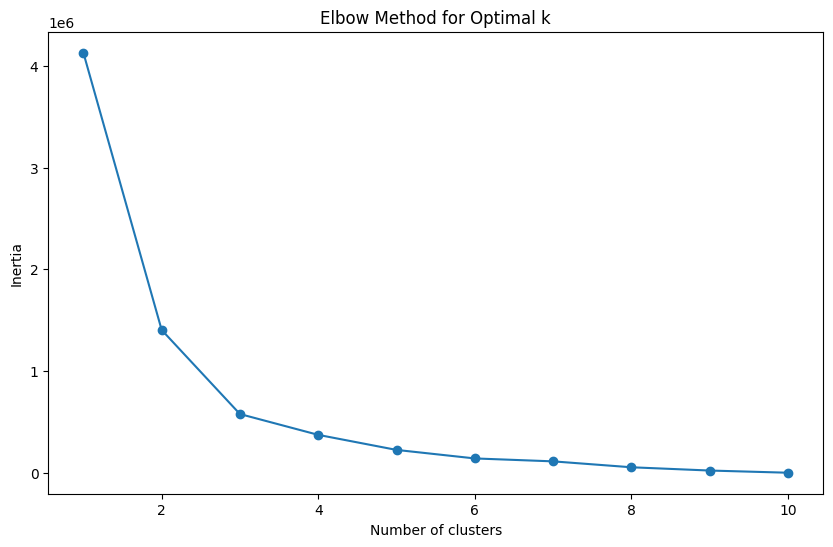

In [4]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(result_df["totalScore"].to_frame())
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [5]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
result_df['cluster'] = kmeans.fit_predict(result_df["totalScore"].to_frame())

In [6]:
# Aggregate cluster information
cluster_summary = result_df.groupby('cluster').agg({
    'totalScore': ['mean', 'std'],
    'visitorId': 'count'
})

print(cluster_summary)

        totalScore           visitorId
              mean       std     count
cluster                               
0         7.957357  0.830647    283304
1         4.950044  1.008972    264194
2        10.764599  0.821903    166669


# Q2


How can we improve customer retention and lifetime value?

- Calculate customer churn rates and identify at-risk customers.
- Analyze the effectiveness of current retention strategies.


### Analysing Channel sources used by Visitors


In [4]:
query = f"""
        SELECT
            fullVisitorID,
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS CustomerPurchaseCount,
            trafficSource.source AS TrafficSource,
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type = '6'
        GROUP BY fullVisitorID, Channel, TrafficSource
        ORDER BY CustomerPurchaseCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

         fullVisitorID   Channel   TotalRevenue  CustomerPurchaseCount    TrafficSource
0  1957458976293878100   Display  4462409180000                    258              dfa
1  7311242886083854158    Direct   174131020000                    236         (direct)
2  9417857471295131045    Direct  1706868080000                    186         (direct)
3  0608915197735218105  Referral    62916120000                    182         (direct)
4  6010250598436085923    Direct   113977940000                    174         (direct)
5  9029794295932939024  Referral   149407040000                    170  mail.google.com
6  4984366501121503466    Direct   123078500000                    164         (direct)
7  7463172420271311409    Direct   132233180000                    158         (direct)
8  6760732402251466726  Referral    88695500000                    156         (direct)
9  4835082938415020542    Direct   103264400000                    154         (direct) 



The most popular channel that is used by customers with a high purchase count


### Calculating yearly churn rates


In [3]:
query = f"""
        SELECT
            fullVisitorID,
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS CustomerPurchaseCount,
            trafficSource.source AS TrafficSource,
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930' AND
            hits.eCommerceAction.action_type = '6'
        GROUP BY fullVisitorID, Channel, TrafficSource
        ORDER BY CustomerPurchaseCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/Users/brandonwoo/Desktop/GenAI/GenAI.backend/GenAI.Backend/.conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         fullVisitorID         Channel  TotalRevenue  CustomerPurchaseCount TrafficSource
0  8851822767477687842        Referral   30878760000                     96      (direct)
1   666582393118140484        Referral   20600080000                     68      (direct)
2  3033366073043100694        Referral   11512000000                     60      (direct)
3  5689475961693395998        Referral   15128780000                     54      (direct)
4  9377429831454005466  Organic Search   20728520000                     52        google
5  8436426603099391262        Referral   37197920000                     52      (direct)
6  5632276788326171571          Direct  673375500000                     42      (direct)
7  4923243433046835289          Direct   14585600000                     40      (direct)
8  5912152563864160997        Referral    9040400000                     40      (direct)
9  6374969976921419865          Direct    7172800000                     40      (direct) 



In [11]:
# https://medium.com/octave-john-keells-group/a-simple-six-step-approach-to-define-customer-churn-in-retail-f401e31e57c0#:~:text=Identifying%20the%20point%20in%20which,time%20to%20proactively%20implement%20interventions.&text=Step%206%3A,is%20identified%20as%20a%20churner.
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Select only the latest date for each visitor and check for their churn status
        RankedDates AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                LowerBoundOneMonthLag,
                ROW_NUMBER() OVER (
                    PARTITION BY fullVisitorID
                    ORDER BY Date DESC
                ) AS rn
            FROM LaggingThreshold
        )

        SELECT Date, fullVisitorID, DailyPurchaseCount, OneMonthMA, LowerBound, LowerBoundOneMonthLag
        FROM RankedDates
        ORDER BY Date
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Sum of purchases by each visitor
grouped_sum = result_df.groupby('fullVisitorID')[
    'DailyPurchaseCount'].sum().reset_index()

grouped_sum = grouped_sum.rename(
    columns={'DailyPurchaseCount': 'HistoricPurchases'})

df = result_df.merge(grouped_sum, on='fullVisitorID',
                     how='left').query("HistoricPurchases > 0")

df['Date'] = pd.to_datetime(df['Date'])

# Only keep the entry of the last purchase
latest_idx = df.groupby('fullVisitorID')['Date'].idxmax()

result_df = df.loc[latest_idx].sort_values(by="Date")

print(result_df, "\n")

             Date        fullVisitorID  DailyPurchaseCount  OneMonthMA  LowerBound  LowerBoundOneMonthLag  HistoricPurchases
1314   2016-08-01  5760753352577829144                  79    2.633333    2.633333                    0.0                 79
449    2016-08-01  6569605994631186947                  36    1.200000    1.200000                    0.0                 36
1348   2016-08-01  2125540555068339394                  25    0.833333    0.833333                    0.0                 25
63     2016-08-01  7589137567725941774                  51    1.700000    1.700000                    0.0                 51
860    2016-08-01  5563168194966233133                  21    0.700000    0.700000                    0.0                 21
...           ...                  ...                 ...         ...         ...                    ...                ...
834749 2017-08-01   024507252193437459                  16    0.533333    0.406213                    0.0                 16


In [12]:
# Those that have not made a purchase within the last 3 months or have a monthly moving average less than the lower bound have a retention risk
max_date = result_df['Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
RetentionRiskCount = len(set(result_df.query(
    "Date <= @three_months_ago | LowerBoundOneMonthLag >= OneMonthMA").fullVisitorID))

# Those that have made a purchase within the last 3 months or have a monthly moving average more than the lower bound do not have a retention risk
RetentionCount = len(set(result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA").fullVisitorID))


result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA")

,Date,fullVisitorID,DailyPurchaseCount,OneMonthMA,LowerBound,LowerBoundOneMonthLag,HistoricPurchases
651404,2017-05-01,536428604379922267,22,0.733333,0.733333,0.0,22
651177,2017-05-01,1749853719127085935,13,0.433333,0.433333,0.0,13
651874,2017-05-01,9740050408987139130,19,0.633333,0.633333,0.0,19
651781,2017-05-01,9565722193439879038,11,0.366667,0.279271,0.0,11
650321,2017-05-01,4501448098783068461,22,2.466667,1.636650,0.0,74
...,...,...,...,...,...,...,...
834749,2017-08-01,024507252193437459,16,0.533333,0.406213,0.0,16
833881,2017-08-01,5199370466032130686,0,0.866667,0.428464,0.0,26
834438,2017-08-01,3614707430894059857,28,0.933333,0.933333,0.0,28
835016,2017-08-01,9591202457292182670,20,0.666667,0.157052,0.0,20


These are the at risk customers as the lagged lower bound is greater or equal to their one month moving average on purchase count


In [13]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those with a retention risk: Less than threshold or have not purchased within the last 3 months
        RetentionRisk AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag >= lt.OneMonthMA AND lt.Date < (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                RetentionRisk
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            RetentionRisk,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          4419         43.154297
1  Organic Search          2360         23.046875
2         Display          1668         16.289062
3          Direct          1455         14.208984
4     Paid Search           239          2.333984
5          Social            96          0.937500
6      Affiliates             3          0.029297
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [14]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those without a retention risk: More than threshold or have purchased within the last 3 months
        Retention AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag < lt.OneMonthMA AND lt.Date >= (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                Retention
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            Retention,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          3695         39.812520
1          Direct          2193         23.628919
2  Organic Search          2133         22.982437
3         Display           884          9.524836
4     Paid Search           307          3.307833
5          Social            63          0.678806
6      Affiliates             6          0.064648
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [15]:
ChurnRate = (RetentionRiskCount /
             (RetentionRiskCount + RetentionCount)) * 100

print("The churn rate for google online store is :", round(ChurnRate, 4), "% \n")

The churn rate for google online store is : 69.2704 % 



### Evaluating current retention strategies


In [16]:

# https://medium.com/@busegungor2303/calculation-of-cltv-and-prediction-of-cltv-71c4f754dd90
query = f"""
        SELECT COALESCE(totals.totalTransactionRevenue, 0)/1e6 AS TotalRevenue, COALESCE(totals.transactions) AS Transactions, fullVisitorId
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Only for those where transactions > 0 since we are looking at customers and not visitors
sub_df = result_df.query("Transactions > 0")
sub_df = sub_df.groupby("fullVisitorId").sum()
sub_df['AvgOrderValue'] = sub_df.TotalRevenue / sub_df.Transactions

print(sub_df.sort_values("AvgOrderValue").query("AvgOrderValue > 0"), '\n')

AvgCustomerValue = sub_df.TotalRevenue.sum() / len(sub_df)
# The average value of a customer that purchases
print("Customer value is: ", round(AvgCustomerValue, 5), '\n')

# The likelihood of a customer making a second purchase
AvgRepeatRate = len(sub_df.query("Transactions > 1")) / len(sub_df)
print("Repeat rate is: ", round(AvgRepeatRate*100, 4), '% \n')

                     TotalRevenue  Transactions  AvgOrderValue
fullVisitorId                                                 
9367883304718826385          1.20             1            1.2
3568593840277988902          3.01             2          1.505
0136876972401975041          2.04             1           2.04
3073830805992104825          2.49             1           2.49
7161524936078300347          2.50             1            2.5
...                           ...           ...            ...
7965265156545901045       4849.60             1         4849.6
5469079519715865124       5608.40             1         5608.4
1957458976293878100     128412.52            22    5836.932727
7496147812697146114       7003.50             1         7003.5
5632276788326171571      16032.75             1       16032.75

[9996 rows x 3 columns] 

Customer value is:  177.62415 

Repeat rate is:  11.6344 % 



In [18]:
# Repeat rate for valuable customers
val_sub_df = sub_df.query(f"AvgOrderValue > {AvgCustomerValue}")
val_RepeatRate = len(val_sub_df.query("Transactions > 1")) / len(val_sub_df)

print(f"The repeat rate for valuable customers is: {
      round(val_RepeatRate*100, 4)}", '% \n')

The repeat rate for valuable customers is: 24.4152 % 



Since the repeat rate for valuable customers is greater then the average (24% > 11.6%), current retention strategies are effective in retaining valuable customers.


### YR


#### Individual visitor avg time on site and total page views


In [27]:
query = """
        SELECT 
            fullVisitorId,
            SUM(totals.pageviews) AS total_pageviews,
            AVG(totals.timeOnSite) AS avg_time_on_site
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY fullVisitorId
        ORDER BY total_pageviews DESC
        LIMIT 100
        """

df = client.query(query).to_dataframe()

print(df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


          fullVisitorId  total_pageviews  avg_time_on_site
0   2194592743396253647              647        796.298507
1   0824839726118485274              576       2057.542857
2   1856749147915772585              556        947.157895
3   8851822767477687842              393        992.875000
4   4086679804074527652              381       1266.333333
..                  ...              ...               ...
95   183286922797817588              126        972.500000
96  9538778820434741432              125       2066.571429
97  4174946983461755352              125       1754.000000
98  0003450834640354121              124        853.500000
99  3447003791318310120              123       2444.000000

[100 rows x 3 columns]


#### description


In [35]:
query = """
        SELECT 
            visitId,
            fullVisitorId,
            date,
            totals.visits,
            totals.pageviews,
            totals.timeOnSite,
            totals.transactions,
            totals.transactionRevenue,
            trafficSource.source,
            geoNetwork.country,
            device.deviceCategory,
            COUNT(DISTINCT visitId) AS unique_visits,
            AVG(totals.timeOnSite) AS avg_time_on_site,
            SUM(totals.transactions) AS total_transactions,
            SUM(totals.transactionRevenue) AS total_revenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY 
            visitId, fullVisitorId, date, totals.visits, totals.pageviews, totals.timeOnSite, totals.transactions, totals.transactionRevenue, trafficSource.source, geoNetwork.country, device.deviceCategory
        ORDER BY 
            total_revenue DESC
        LIMIT 1000
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        visitId        fullVisitorId      date  visits  pageviews  timeOnSite  transactions  transactionRevenue       source        country deviceCategory  unique_visits  avg_time_on_site  total_transactions  total_revenue
0    1474035643  5632276788326171571  20160916       1         89        1486             1         16023750000     (direct)  United States        desktop              1            1486.0                   1    16023750000
1    1474965281  4067986469497332117  20160927       1         26        3883             1          3388800000     (direct)          Japan        desktop              1            3883.0                   1     3388800000
2    1474931750  1044832976156649069  20160926       1         31        1257             1          2399700000     (direct)         Canada        desktop              1            1257.0                   1     2399700000
3    1473950759  3979618861854336423  20160915       1        202        6596             1          1890180

#### description


In [36]:
query = """
        WITH customer_segments AS (
            SELECT 
                fullVisitorId,
                COUNT(DISTINCT visitId) AS visit_count,
                AVG(totals.timeOnSite) AS avg_time_on_site,
                SUM(totals.transactions) AS total_transactions,
                SUM(totals.transactionRevenue) AS total_revenue,
                geoNetwork.country,
                device.deviceCategory
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
            GROUP BY 
                fullVisitorId, geoNetwork.country, device.deviceCategory
        )
        SELECT 
            country,
            deviceCategory,
            AVG(visit_count) AS avg_visits,
            AVG(total_transactions) AS avg_transactions,
            AVG(total_revenue) AS avg_revenue
        FROM 
            customer_segments
        GROUP BY 
            country, deviceCategory
        ORDER BY 
            avg_revenue DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


           country deviceCategory  avg_visits  avg_transactions   avg_revenue
0            Japan        desktop    1.133264               1.0  3.388800e+09
1           Canada        desktop    1.401084               1.0  4.599044e+08
2           Taiwan        desktop    1.218989               2.0  2.583300e+08
3        Hong Kong        desktop    1.243902               1.0  2.396650e+08
4      Puerto Rico        desktop    1.120000               1.0  2.249700e+08
..             ...            ...         ...               ...           ...
399          Malta         mobile    1.000000               NaN           NaN
400         Kuwait         tablet    1.000000               NaN           NaN
401        Réunion         tablet    1.000000               NaN           NaN
402      Hong Kong         tablet    1.000000               NaN           NaN
403  French Guiana         mobile    1.000000               NaN           NaN

[404 rows x 5 columns]


#### description


In [45]:
query = """
        SELECT
            CASE WHEN totals.newVisits = 1 THEN 'New' ELSE 'Returning' END AS visitor_type,
            COUNT(DISTINCT fullVisitorId) AS visitor_count,
            SUM(totals.pageviews) AS total_pageviews,
            AVG(totals.timeOnSite) AS avg_time_on_site,
            AVG(totals.bounces) AS avg_bounces
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY
            visitor_type
        """

query_job = client.query(query)

result_df = query_job.to_dataframe()


print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


  visitor_type  visitor_count  total_pageviews  avg_time_on_site  avg_bounces
0    Returning           8921           105640        413.895152          1.0
1          New          55555           221723        235.985886          1.0


#### description


In [48]:
query = """
        WITH UserVisits AS (
            SELECT
                fullVisitorId,
                visitNumber
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
            GROUP BY fullVisitorId, visitNumber
        )

        SELECT
            CASE
                WHEN UserVisits.visitNumber = 1 THEN 'New User'
                ELSE 'Returning User'
            END AS UserType,
            COUNT(*) AS Sessions,
            AVG(sessions.totals.timeOnSite) AS AvgSessionDuration,
            SUM(sessions.totals.bounces) / COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS sessions
        JOIN UserVisits
        ON sessions.fullVisitorId = UserVisits.fullVisitorId
        WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY UserType
        ORDER BY Sessions DESC
        """

row = client.query(query)

result_df = row.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         UserType  Sessions  AvgSessionDuration  BounceRate
0  Returning User     79806          585.249634    0.398980
1        New User     64252          265.122362    0.503969


#### description


In [42]:
query = """
        SELECT
            device.deviceCategory,
            AVG(totals.timeOnSite) AS avg_time_on_site,
            AVG(totals.pageviews) AS avg_pageviews,
            AVG(totals.bounces) AS avg_bounce_rate
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY
            device.deviceCategory
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


  deviceCategory  avg_time_on_site  avg_pageviews  avg_bounce_rate
0        desktop        283.196537       4.632363              1.0
1         mobile        268.329531       4.369049              1.0
2         tablet        295.453237       5.385432              1.0


#### description


In [46]:
query = """
        SELECT
            fullVisitorId,
            SUM(totals.pageviews) AS total_pageviews,
            SUM(totals.hits) AS total_hits,
            AVG(totals.timeOnSite) AS avg_time_on_site,
            SUM(totals.bounces) AS total_bounces
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
        GROUP BY
            fullVisitorId
        ORDER BY
            total_pageviews DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


             fullVisitorId  total_pageviews  total_hits  avg_time_on_site  total_bounces
0      2194592743396253647              647         757        796.298507             19
1      0824839726118485274              576         717       2057.542857             10
2      1856749147915772585              556         666        947.157895              7
3      8851822767477687842              393         557        992.875000              2
4      4086679804074527652              381         567       1266.333333           <NA>
...                    ...              ...         ...               ...            ...
59116   246886865255684914                1           1               NaN              1
59117  0670569165766150000                1           1               NaN              1
59118  2154708034844551478                1           1               NaN              1
59119  1335370086170802517                1           1               NaN              1
59120  62721146851801

#### description


In [49]:
query = """
        SELECT
            fullVisitorId,
            COUNT(totals.transactions) AS total_transactions,
            SUM(totals.transactionRevenue) AS total_revenue,
            AVG(totals.transactionRevenue) AS avg_revenue_per_transaction
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            totals.transactions IS NOT NULL
        GROUP BY
            fullVisitorId
        ORDER BY
            total_revenue DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df)

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


             fullVisitorId  total_transactions  total_revenue  avg_revenue_per_transaction
0      1957458976293878100                  16    77113430000                 4.819589e+09
1      5632276788326171571                   1    16023750000                 1.602375e+10
2      9417857471295131045                   5    15170120000                 3.034024e+09
3      4471415710206918415                   4    11211100000                 2.802775e+09
4      4984366501121503466                  16     9513900000                 5.946188e+08
...                    ...                 ...            ...                          ...
10017  0628708827036512143                   1           <NA>                          NaN
10018  4330494225147030149                   1           <NA>                          NaN
10019  4019173914403244131                   1           <NA>                          NaN
10020  9137922581159198144                   1           <NA>                          NaN

#### description


In [62]:
query_social_engagement = """
                            SELECT
                                channelGrouping,
                                SUM(totals.transactions) AS total_transactions,
                                SUM(totals.transactionRevenue) AS total_revenue,
                                COUNT(DISTINCT fullVisitorId) AS total_visitors
                            FROM
                                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                                UNNEST(hits) AS hit
                            GROUP BY
                                channelGrouping
                            """

df_social_engagement = client.query(query_social_engagement).to_dataframe()
print(df_social_engagement.head())

/opt/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


  channelGrouping  total_transactions   total_revenue  total_visitors
0  Organic Search              149447  18235868990000          311607
1         Display                5983   5120535430000            4103
2        Referral              210812  28666307920000           65661
3      Affiliates                 334     27260690000           13400
4          Direct              102671  23535451680000          109830


# Q3


What are the most effective marketing channels and campaigns?

- Evaluate the ROI of different marketing channels.

- Analyze the impact of various promotional campaigns on sales - Ads & Promotion position


### Evalutaing revenue of different marketing channels


In [19]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            trafficSource.source AS TrafficSource,
            COUNT(fullVisitorID) AS UserCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type != '0'
        GROUP BY TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel         TrafficSource  UserCount
0  Organic Search                google     339732
1        Referral              (direct)     338334
2          Direct              (direct)     234482
3  Organic Search              (direct)     197849
4     Paid Search                google      29673
5          Social           youtube.com      26201
6     Paid Search              (direct)      21580
7         Display                   dfa      14255
8      Affiliates              Partners      10965
9        Referral  analytics.google.com       6205 



Using the dataframe above, we can find which platform and channel is the most popular.


1. **Organic Search**: Traffic that comes from search engines like Google or Bing when users find your website through unpaid search results. It’s driven by SEO efforts to optimize website content and improve rankings.

2. **Referral**: Visitors who come to your site from links on other websites. This can include links from blogs, forums, or other online platforms that lead users to your content.

3. **Direct**: Traffic from users who type your website URL directly into their browser or have it bookmarked. This indicates brand awareness and loyalty, as these users are actively seeking your site.

4. **Paid Search**: Traffic generated from paid advertising on search engines (like Google Ads). Advertisers bid on keywords to have their ads appear in search results, driving targeted traffic to their websites.

5. **Social**: Visitors who arrive at your site from social media platforms like Facebook, Twitter, Instagram, or LinkedIn. This includes both organic posts and paid advertisements on these platforms.

6. **Display**: Traffic generated from display advertising, which includes banner ads, video ads, and other visual ads placed on websites across the internet. These ads are typically targeted based on user behavior and interests.

7. **Affiliates**: Traffic that comes from affiliate marketing, where other websites or influencers promote your products or services in exchange for a commission on sales generated through their referrals.


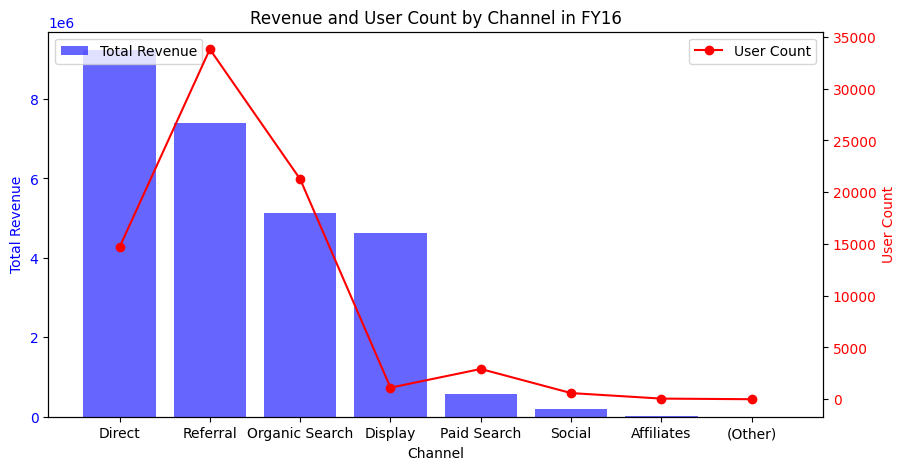

          Channel  TotalRevenue  UserCount
0          Direct    9231074.22      14684
1        Referral    7395921.38      33812
2  Organic Search    5131651.19      21259
3         Display    4614033.64       1120
4     Paid Search     568974.68       2924
5          Social     198628.86        594
6      Affiliates       8138.52         62
7         (Other)         23.98          2 



In [13]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue)/1e6 AS TotalRevenue,
            COUNT(fullVisitorID) AS UserCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            -- action_type = 6 is for the purchase action
            hits.eCommerceAction.action_type = '6'
        GROUP BY Channel
        ORDER BY TotalRevenue DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(result_df['Channel'], result_df['TotalRevenue'],
        color='b', alpha=0.6, label='Total Revenue')
ax1.set_xlabel('Channel')
ax1.set_ylabel('Total Revenue', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(result_df['Channel'], result_df['UserCount'],
         color='r', marker='o', label='User Count')
ax2.set_ylabel('User Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Revenue and User Count by Channel in FY16')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Referral searches are the most popular as it attracts the greatest number of users. However, focusing on the direct channel is more attractive for businesses as it tend to generate more revenue.


In [43]:
# For each page title, find the number of customers and how they are searching their products and purchasing them
query = f"""
        SELECT
            IF(LENGTH(hits.page.pageTitle) <= 20, hits.page.pageTitle, CONCAT(SUBSTR(hits.page.pageTitle, 1, 20), '...')) AS PageTitle,
            channelGrouping AS Channel,
            COUNT(fullVisitorID) AS VisitorCount,
            SUM(IF(totals.transactions IS NULL, 0, totals.transactions)) AS TransactionCount,
            SUM(totals.totalTransactionRevenue/1e6) AS TotalRevenue
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.page.pageTitle NOT LIKE '%Checkout%'
            AND hits.page.pageTitle NOT LIKE '%Home%'
            AND hits.page.pageTitle NOT LIKE '%Cart%'
            AND hits.page.pageTitle NOT LIKE '%Google%'
            AND hits.page.pageTitle NOT LIKE '%Payment%'
            AND hits.page.pageTitle NOT LIKE '%results%'
            AND totals.transactions > 0
        GROUP BY PageTitle, Channel
        ORDER BY VisitorCount DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                   PageTitle         Channel  VisitorCount  TransactionCount  TotalRevenue
0             Men's-T-Shirts        Referral          3423              3573     493624.68
1                     Office        Referral          2553              2691     737288.10
2                  Drinkware        Referral          2193              2362     441055.28
3             Men's-T-Shirts  Organic Search          2166              2698     410113.98
4                     Office  Organic Search          1896              2107     339173.57
..                       ...             ...           ...               ...           ...
847  Waze Pack of 9 Decal...          Direct             1                 1         13.99
848  Android 24 oz botell...          Direct             1                 7       3775.80
849  Spiral Notebook and ...         Display             1                 1        191.18
850  Bic Intensity Clic G...          Direct             1                 1        203.35

Referral and organic searches are clearly the most popular traffic channels and a higher traffic generally equates to a higher transaction count


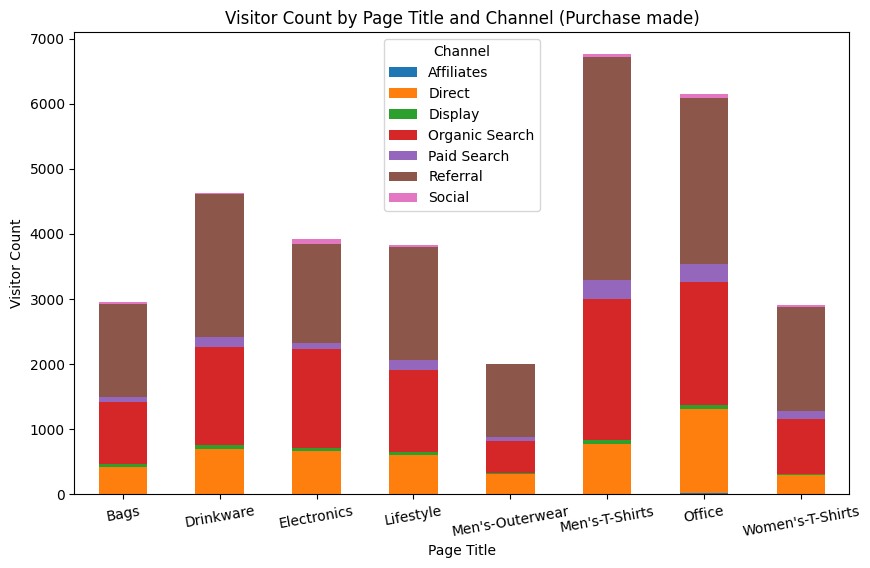

In [55]:
topSevenPageTitles = result_df.drop(columns=['Channel']).groupby("PageTitle").sum().sort_values(
    "VisitorCount", ascending=False).head(8).query("PageTitle != 'Page Unavailable'").index
plot_df = result_df.query("PageTitle in @topSevenPageTitles")


grouped_df = plot_df.groupby(['PageTitle', 'Channel'])[
    'VisitorCount'].sum().unstack(fill_value=0)

# Plotting
grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Page Title')
plt.ylabel('Visitor Count')
plt.title('Visitor Count by Page Title and Channel (Purchase made)')
plt.legend(title='Channel')
plt.xticks(rotation=10)

# Show plot
plt.show()

For the top seven most popular categories, the referral channel emerges as the leading channel of purchases. This indicates that business should prioritize promoting its products through referral channels over other marketing channels.


### Promotional campaigns (Ads)


In [23]:
query = """
        SELECT  
                trafficSource.adContent AS AdContent,
                trafficSource.adwordsClickInfo.page AS AdPage, 
                trafficSource.adwordsClickInfo.slot AS AdPosition, 
                SUM(COALESCE(totals.transactions, 0)) AS TotalTransactions, 
                SUM(totals.hits) AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY AdContent, AdPage, AdPosition
        ORDER BY TotalTransactions DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

                          AdContent  AdPage AdPosition  TotalTransactions     Hits
0                              None    <NA>       None              11638  3989702
1                              None       1        Top                326   108559
2     Google Merchandise Collection       1        Top                119    33812
3                              None       1        RHS                  6     1233
4           Full auto ad IMAGE ONLY    <NA>       None                  5     2723
5               Google Online Store       1        Top                  4     3459
6        Display Ad created 3/11/14    <NA>       None                  3     4581
7            Swag with Google Logos       1        Top                  3      553
8     {KeyWord:Google Branded Gear}       1        Top                  3      460
9                      20% discount    <NA>       None                  2      554
10  {KeyWord:Want Google Stickers?}       1        Top                  2      323
11  

In [24]:
query = """
        SELECT  
                trafficSource.adContent AS AdContent,
                trafficSource.adwordsClickInfo.page AS AdPage, 
                trafficSource.adwordsClickInfo.slot AS AdPosition, 
                SUM(COALESCE(totals.transactions, 0)) AS TotalTransactions, 
                SUM(totals.hits) AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY AdContent, AdPage, AdPosition
        ORDER BY TotalTransactions DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

sub_df = result_df.query(
    "AdPosition.isna() | ~AdPosition.isna()")
sub_df["AdPage"] = sub_df["AdPage"].notna()
sub_df["AdPosition"] = sub_df["AdPosition"].notna()

sub_df = sub_df.groupby(["AdPage", "AdPosition"])[
    ["TotalTransactions", "Hits"]].sum().reset_index()
sub_df['TransactionRate'] = sub_df.TotalTransactions / sub_df.Hits

print(sub_df, '\n')
print("Likelihood of purchase after viewing an Ad is: ",
      round((sub_df.at[1, "TransactionRate"] - sub_df.at[0, "TransactionRate"]) / sub_df.at[0, "TransactionRate"]*100, 4),  "%", " greater than when no Ad is viewed.")

   AdPage  AdPosition  TotalTransactions     Hits  TransactionRate
0   False       False              11650  3999228         0.002913
1    True        True                465   150753         0.003085 

Likelihood of purchase after viewing an Ad is:  5.8857 %  greater than when no Ad is viewed.


### Promotional Discounts

To analyze the different promotional campaigns, we examine the daily price fluctuations and compare them with the average price of each product over a one-year period. This helps us determine the daily discounts available to customers. We increment the discount rate to assess its impact on transactional revenue, allowing us to evaluate the effectiveness of the discounts.

In [22]:
import matplotlib.colors as mcolors
import matplotlib.dates as mdates


In [261]:
query = """
        SELECT 
            FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS date,
            product.v2ProductCategory AS Category,
            product.v2ProductName AS product_name,
            totals.transactions AS transactions,
            totals.totalTransactionRevenue AS revenue,
            product.localProductPrice/1e6 AS price
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        WHERE totals.totalTransactionRevenue > 0
        ORDER BY date, product_name
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Clean categories
result_df = clean_categories(result_df)

In [344]:
test_df = result_df

test_df = test_df.groupby(by = ["product_name", "date"]).mean("price").reset_index()

product_info = test_df.groupby(by = ["product_name"]).mean("price").reset_index()
product_info = product_info.set_index("product_name")

product_info = product_info["price"]
test_df["promotion"] = False


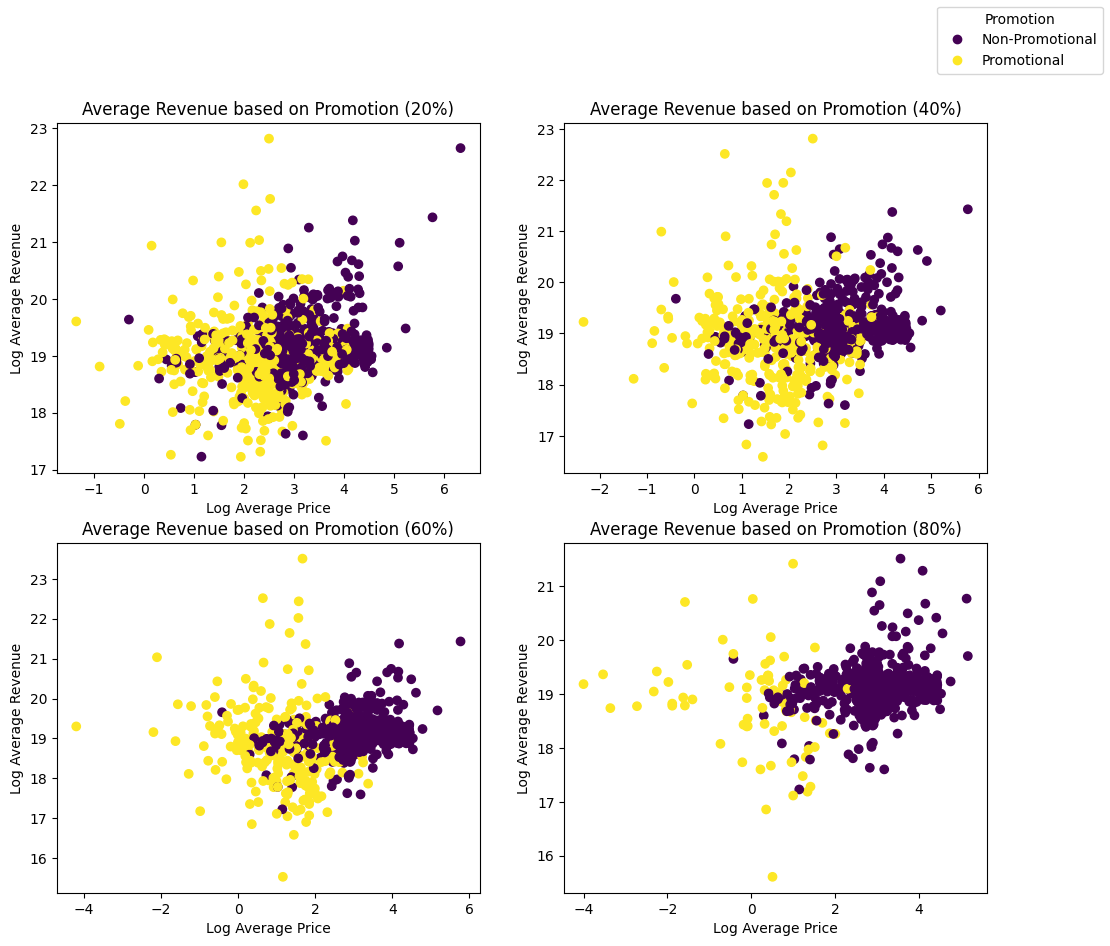

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [359]:
test_df = test_df.groupby(by = ["product_name", "date"]).mean("price").reset_index()

product_info = test_df.groupby(by = ["product_name"]).mean("price").reset_index()
product_info = product_info.set_index("product_name")

product_info = product_info["price"]
test_df["promotion"] = False


def discount(row,rate):
    if row["price"] < (1 - rate/100) * product_info.loc[row["product_name"]]:
        return True
    else:
        return False

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(1, 5):
    test_df["promotion"] = test_df.apply(discount, axis=1, args=(i * 20,))

    average_revenue_per_product = (test_df.groupby(["product_name", "promotion"]).sum("revenue")/test_df.groupby(["product_name", "promotion"]).count()).reset_index()
    average_revenue_per_product["log_price"] = np.log(average_revenue_per_product["price"])
    average_revenue_per_product["log_revenue"] = np.log(average_revenue_per_product["revenue"])

    # Create a new figure for each scatter plot
    plt.figure(figsize=(4, 4))

    # Create scatter plot
    scatter = axes[i - 1].scatter(
        x=average_revenue_per_product["log_price"],
        y=average_revenue_per_product["log_revenue"],
        c=average_revenue_per_product["promotion"].astype('category').cat.codes,  # Convert promotion to numeric for coloring
        cmap='viridis'  # Colormap for different promotion categories
    )

    # Add title and labels
    axes[i - 1].set_title(f"Average Revenue based on Promotion ({i * 20}%)")
    axes[i - 1].set_xlabel("Log Average Price")
    axes[i - 1].set_ylabel("Log Average Revenue")

handles, labels = scatter.legend_elements()
fig.legend(handles, ["Non-Promotional", "Promotional"], title="Promotion", loc='upper right')
plt.tight_layout()
plt.show()


### Key Obeservation

- Across all discount level, revenue generally increases as price increases albeit with high variability. This shows a weak positive correlation between price and revenue
- Higher promotions concentrate the non-promotional variability but the promotional prices seem to continue have high variance
- At 40% discount, the overall revenue of promotional products is higher than non-promotional products. 40% discount might be close to the ideal balance between lower prices and higher revenue
- In conclusion, the discount in prices does not seem to have a major impact on the total revenue from the transactions. This might be becasue of poor marketing of the discount or the increase in demand for the products is outweight by the lower prices. 